In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

boston = fetch_openml(name="boston", version=1, as_frame=True)

X, y = boston.data, boston.target

X = np.array(X)
y = np.array(y)


### Calculating bias and variance using bootstrap

$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{noise}} + 
    \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{bias}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{variance}},
$$

* $\mu(X)$ — algorithm trained on a sample $X = \{(x_1, y_1), \dots, (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — the prediction of the algorithm trained on the sample $X$ for the object $x$;
* $\mathbb{E}_{X}$ — the expectation over all possible samples;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — the "average" prediction of the algorithm trained on all possible samples $X$ for the object $x$.


### Approximate calculation of integrals
For most data models and learning algorithms, it is not possible to calculate mathematical expectations analytically in formulas. However, mathematical expectations can be estimated approximately. To estimate the mathematical expectation $\mathbb{E}_{\bar z} f(\bar z)$ functions of a multivariate random variable $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, it is possible to generate a sample from a distribution $p(\bar z)$ and average the value of the function on the elements of this sample:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$



### Evaluation $\mathbb{E}_{x, y}$
Estimating the mean values ​​for $x$ and for $x, y$ that appear in all three components of the decomposition is easy because we have a sample of objects from the data distribution $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
where $N$ is the number of objects in the sample, $\{(x_i, y_i)\}_{i=1}^N$ - the sample data.

### Evaluation $\mathbb{E}_X$ using bootstrap
To estimate the mathematical expectation for $X$, we need a sample of samples:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
where $X_j$ is the $j$-th sample. To obtain them, we can use bootstrapping, a method for generating samples based on feature selection with replacement. To form one sample, we will select the index of the object $i \sim \text{Uniform}(1 \dots N)$ $N$ times and add the $i$-th pair (object, target variable) to the sample. As a result, each sample may contain duplicate objects, and some objects may not be included in some samples at all.

### Final algorithm for estimating bias and spread of algorithm $a$
1. Generate $s$ samples $X_j$ using the bootstrap method.
1. On each sample $X_j$, train algorithm $a_j$.
1. For each sample $X_j$, determine the set of objects $T_j$ that are not included in it (out-of-bag). Calculate the predictions of algorithm $a_j$ on objects $T_j$.

Since we have only one answer for each object, we will consider noise to be 0, and $\mathbb{E}[y|x]$ to be equal to the available correct answer for object $x$.

Final estimates:
* Bias: for one object - the square of the difference between the average prediction and the correct answer. The average prediction is taken only for those algorithms $a_j$ for which this object was included in the out-of-bag sample $T_j$. To obtain the overall bias, average the biases across objects.
* Spread: for one object, the sample variance of the predictions of algorithms $a_j$ for which this object was included in the out-of-bag sample $T_j$. To obtain the overall spread, average the spreads across objects.
* Error $L$: average the squares of the differences between the prediction and the correct answer across all predictions made for all objects.

The result should be that the error is approximately equal to the sum of the bias and spread!

In [2]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    num_oob = np.zeros(X.shape[0])
    sum_oob = np.zeros(X.shape[0])
    average_oob = np.zeros(X.shape[0])
 
    error = 0
    variance = 0
    
    cur_num = 0
    
    df_out = pd.DataFrame()
    df_predict = pd.DataFrame()

    # generating S samples using bootstrap method
    for i in range(num_runs): 
        first = np.arange(X.shape[0])

        sample = np.random.choice(X.shape[0],size = X.shape[0])
        regr = regressor.fit(X[sample], y[sample])
        

        out = list(set(first)-set(sample))

        df1 = pd.DataFrame(np.array(out))
        df_out = pd.concat([df_out,df1], ignore_index=True, axis=1)
        
        pred_out = regr.predict(X[out]) # predicted value h_b(x) for each x in T_b
        df2 = pd.DataFrame(np.array(pred_out))
        df_predict = pd.concat([df_predict,df2], ignore_index=True, axis=1)
        
        error += np.dot((pred_out - y[out]).T,pred_out - y[out])
        
        cur_num += len(pred_out)
        num_oob[out] += 1 # arr will store the number of occurrences of each element that was not included in the selection
        sum_oob[out]+= pred_out # sum of objects that are not included in the sample

        
    average_oob = sum_oob/num_oob
    average_oob = np.insert(average_oob, len(average_oob), 0) # crutch - to equalize different lengths of arrays
    y = np.insert(y, len(y), 0)
    
    df_out = df_out.fillna(X.shape[0])
    df_out = df_out.astype(int)
    df_out = df_out.to_numpy()
    
    outs = average_oob[df_out]
    
    df_predict = df_predict.fillna(0) # crutch to equalize the dimensions of this array
    df_predict = df_predict.to_numpy()
    
    variance = np.trace(np.dot((df_predict - outs).T,df_predict - outs)) # the sum of the diagonal elements - that's where the scalar product of the columns lies
    
    bias = np.dot((average_oob-y).T, average_oob-y)

    
    return bias/X.shape[0],error/cur_num, variance/cur_num

In [3]:
bias, error, variance = compute_biase_variance(LinearRegression(), X, y)

In [4]:
print(bias, error, variance)

23.70429282859196 24.583371572203646 0.9235403441571245


For regression, the bias is several times greater than the spread. Linear models do not deviate much from each other - respectively, the spread is low, and as a rule, they predict the true dependence poorly => large bias.

In [5]:
from sklearn.tree import DecisionTreeRegressor

bias, error, variance = compute_biase_variance(DecisionTreeRegressor(), X, y)

In [6]:
print(bias, error, variance)

9.97151648427691 22.7511499742146 12.793997769517881


From here it is clear that variance is large. This follows from the fact that the decision tree is heavily overtrained for single objects. The bias, as can be seen, is less than in regression. This occurs because the tree adapts quite well to the initial sample.

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
bias, error, variance = compute_biase_variance(RandomForestRegressor(), X, y)

In [9]:
print(bias, error, variance)

10.570800437457756 12.863298875702391 2.279454275819342


As you can see, the bias in RF is the same as for a single decision tree. RF is built using bagging. The bagging bias is the same as for a single model. The spread has become smaller, -> the spread will decrease more if the samples are less correlated. (the second term is the covariance of two samples, multiplied by the coefficient)

In [10]:
def bagging(regressor, X, y, num_runs=100):
    
    num_oob = np.zeros(X.shape[0])
    sum_oob = np.zeros(X.shape[0])
    average_oob = np.zeros(X.shape[0])
    
    error = 0
    variance = 0
    
    cur_num = 0
    
    df_predict = pd.DataFrame()

    # generating S samples using bootstrap method
    for i in range(num_runs): 
        first = np.arange(X.shape[0])
        
        num_oob_cur = np.zeros(X.shape[0])
        sum_oob_cur = np.zeros(X.shape[0])
        average_oob_cur = np.zeros(X.shape[0])
        
        y_oob_cur = np.zeros(X.shape[0])
        
        
        for j in range(100): # let's take 100 models for bagging
        
            sample = np.random.choice(X.shape[0],size = X.shape[0])
            regressor.fit(X[sample], y[sample])
        

            out = list(set(first)-set(sample))
            pred_out = regressor.predict(X[out])
            
            num_oob[out] += 1 # the number of occurrences of each element that was not included in the sample will be stored
            sum_oob[out]+= pred_out # sum of objects that are not included in the sample
            
            num_oob_cur[out] += 1 # counter for averaging by bagging
            sum_oob_cur[out]+= pred_out 
            
            y_oob_cur[out] += y[out]
            
            
            
        y_oob_cur =   y_oob_cur/num_oob_cur
        
        average_oob_cur = sum_oob_cur/num_oob_cur # these are the model predictions for iteration 1 of bagging
        df2 = pd.DataFrame(np.array(average_oob_cur))

        
        df_predict = pd.concat([df_predict,df2], ignore_index=True, axis=1)
        
  
        error += np.dot((average_oob_cur - y_oob_cur).T,average_oob_cur - y_oob_cur)
        
        cur_num += len(average_oob_cur)

        
    average_oob = sum_oob/num_oob
    
    df_predict = df_predict.to_numpy()
    bias = np.dot((average_oob-y).T, average_oob-y)
    
    average_oob.shape += (1,)
    variance = np.trace(np.dot((df_predict - average_oob).T,df_predict - average_oob)) # sum of the diagonal elements - that's where the scalar product of the columns lies
    
    
    return bias/X.shape[0],error/cur_num, variance/cur_num
        

In [11]:
bias, error, variance = bagging(LinearRegression(), X, y)

In [12]:
print(bias, error, variance)

23.72083464962467 23.74894573648149 0.024140133687762105


As we can see, for linear regression, bagging provides the same bias. However, the variance, although it was small, has decreased by 50 times.

In [13]:
bias, error, variance = bagging(DecisionTreeRegressor(), X, y)

In [14]:
print(bias, error, variance)

10.20941422814497 10.560348757176813 0.3493678945473818


The bias remains the same as before, but the variance has decreased.

In [15]:
bias, error, variance = bagging(RandomForestRegressor(), X, y)

In [16]:
print(bias, error, variance)

10.618347521524134 10.676918261678276 0.05956714996486597


As we can see, the bias remains almost the same. However, the variance has significantly decreased. This can also be explained by the fact that the models are poorly correlated. If they were more strongly correlated, the variance would be smaller, but not to such a large extent.

### Visualization of predictions of basic bagging algorithms

In [17]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    first = np.arange(X.shape[0])
    test = np.random.choice(X.shape[0],size = num_test_objects)
    train = list(set(first)-set(test))
    X_test = X[test]
    y_test = y[test]
    X_train = X[train]
    y_train = y[train]
    df = pd.DataFrame(columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    
    for i in range(num_runs):
        sample = np.random.choice(X_train.shape[0],size = X_train.shape[0])
        
        regressor.fit(X_train[sample], y_train[sample])
        
        pred_out = regressor.predict(X_test)
        df.loc[i] = pred_out
    

    fig, ax = plt.subplots()
    fig.set_figwidth(6)    
    fig.set_figheight(4) 
    
    for i  in range(num_test_objects):
        ax.scatter([i]*100, df[df.columns[i]],c = 'r')
        
    for i  in range(num_test_objects): 
        ax.scatter([i], y_test[i],c = 'black')


    ax.set_title(title, fontsize=8)

    ax.set_xlabel("Test sample objects", fontsize=8)
    ax.set_ylabel("Predictions of test sample objects", fontsize=8)
    
    plt.show()
  
    return num_runs

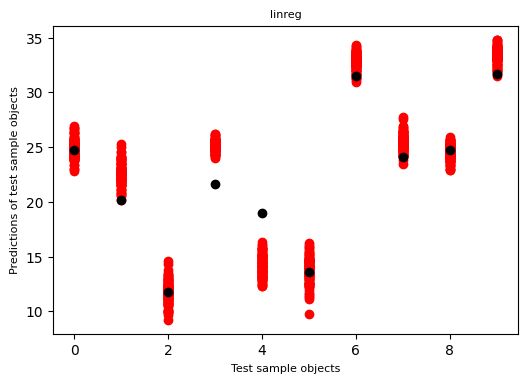

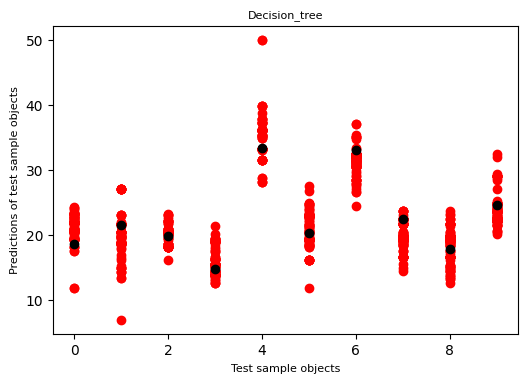

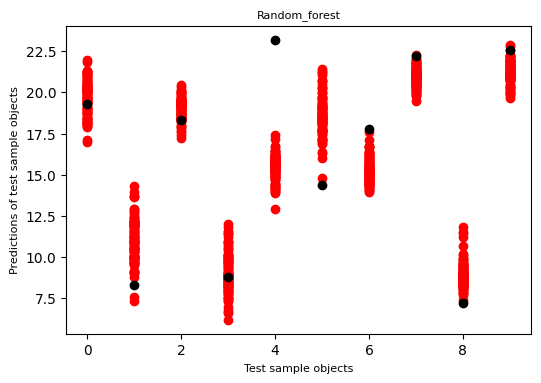

In [18]:
el = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
el_title = ['linreg', 'Decision_tree', 'Random_forest']
i =0
for j  in range(3):

    plot_predictions(el[j], X, y, title = el_title[j])

From the graph it is clear that the Decision Tree has a large spread - as some objects deviate strongly in both directions.


For linear regression, it's evident that the data points are closely clustered together, which means the variance is very low.

Based on the graphs, Decision Tree has minimal bias, as the black points approximately fall in the center of the red distribution. For Random Forest, the bias is similar to that of Decision Tree.

### Changes in Bias and Variance with Hyperparameter Tuning

Graphs showing the dependence of bias and variance on the hyperparameters of a decision tree, such as `max_depth` (from 1 to 10) and `max_features` (from 1 to X.shape[1]).

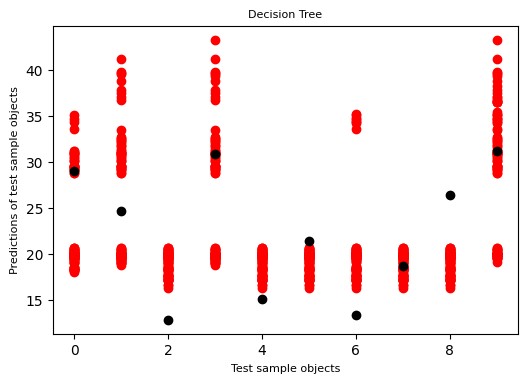

max_depth =  1


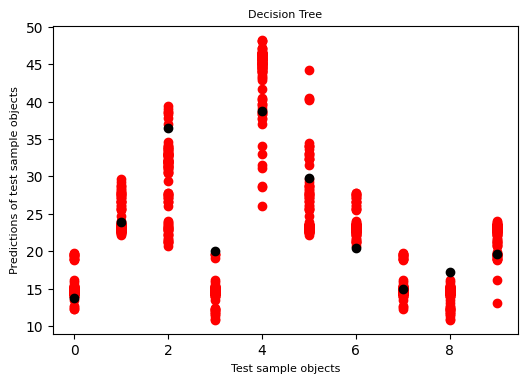

max_depth =  2


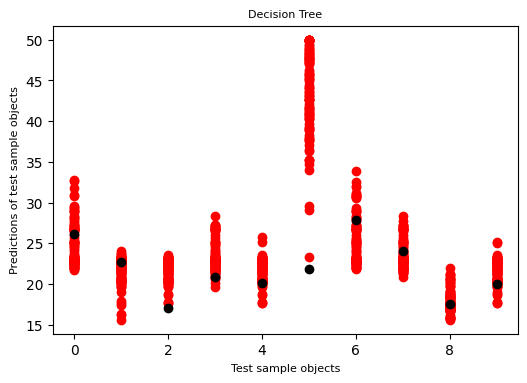

max_depth =  3


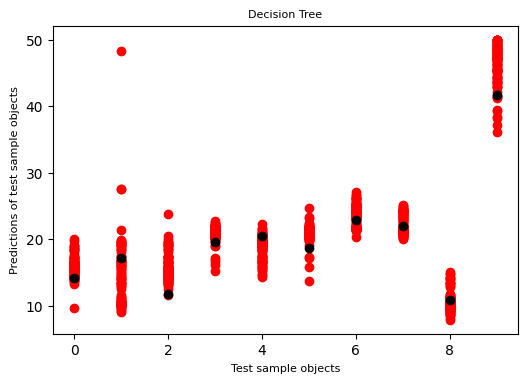

max_depth =  4


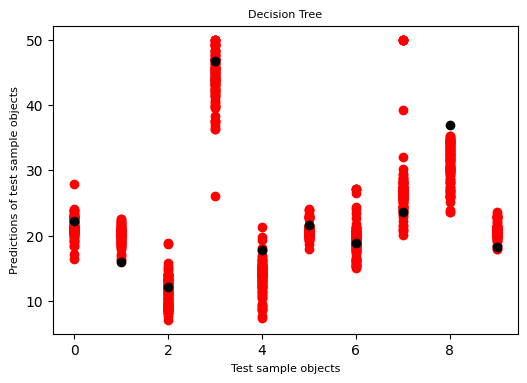

max_depth =  5


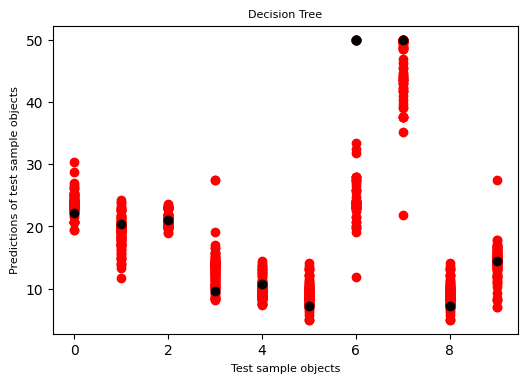

max_depth =  6


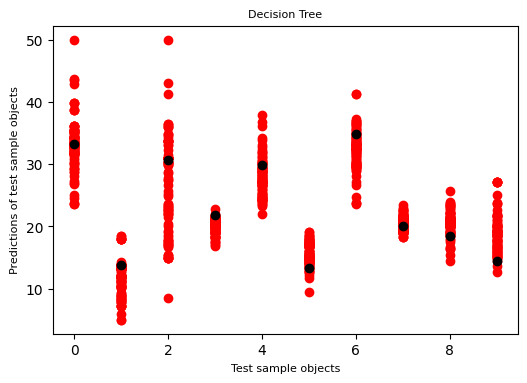

max_depth =  7


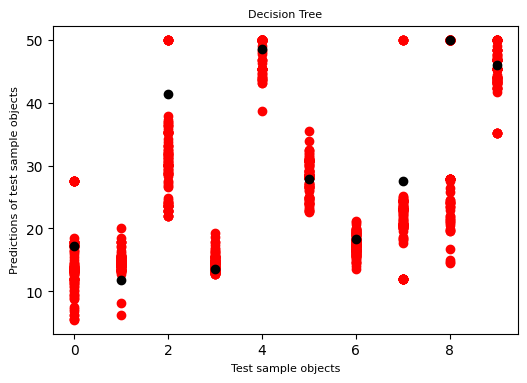

max_depth =  8


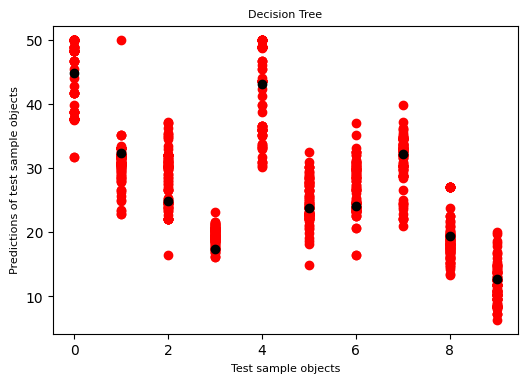

max_depth =  9


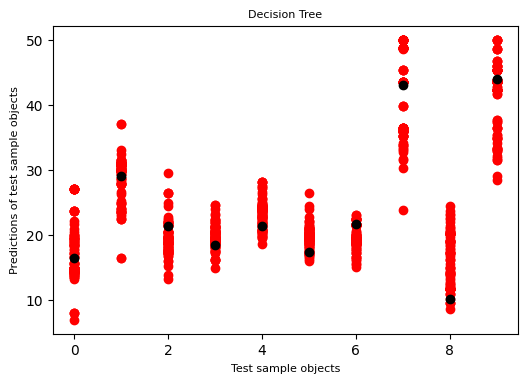

max_depth =  10


In [19]:
for j  in range(1, 11):

    plot_predictions(DecisionTreeRegressor(max_depth = j), X, y, title = "Decision Tree")
    print("max_depth = ", j)



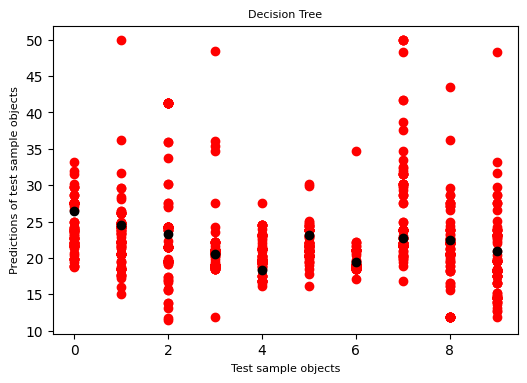

max_features =  1


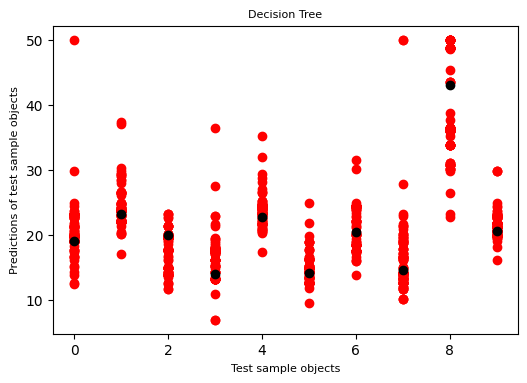

max_features =  2


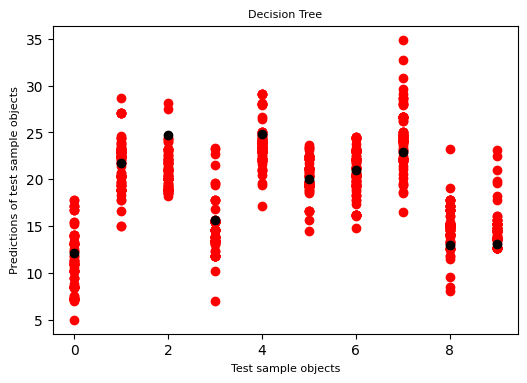

max_features =  3


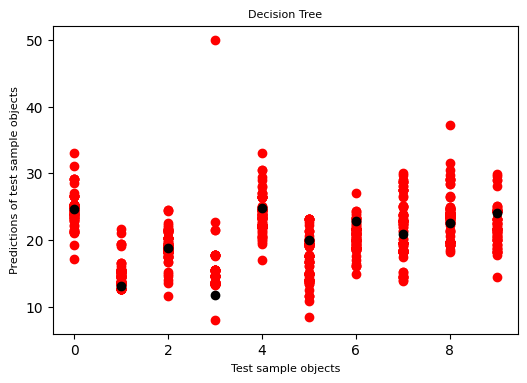

max_features =  4


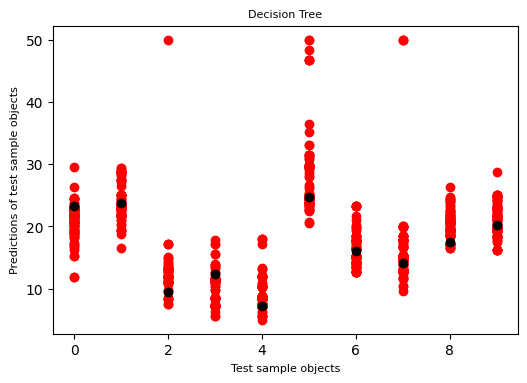

max_features =  5


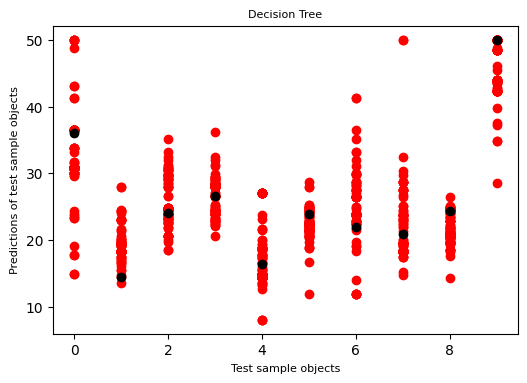

max_features =  6


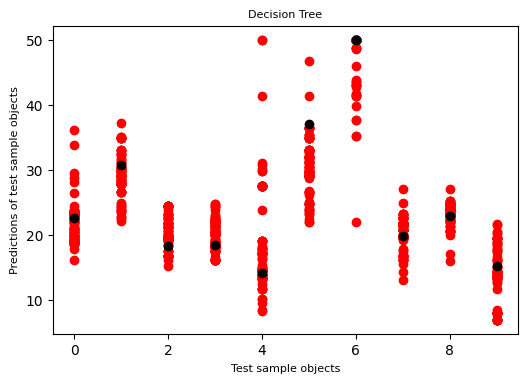

max_features =  7


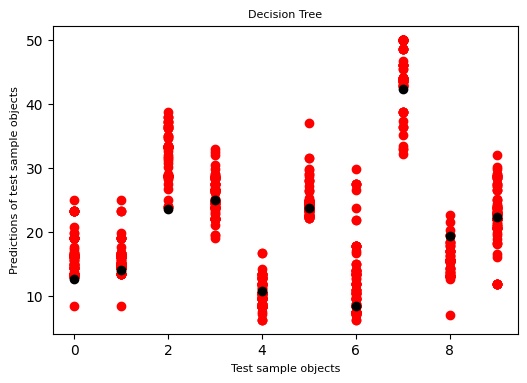

max_features =  8


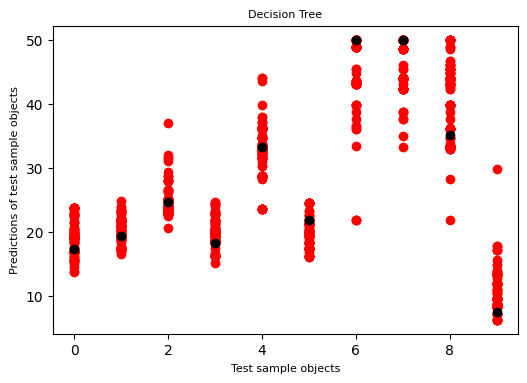

max_features =  9


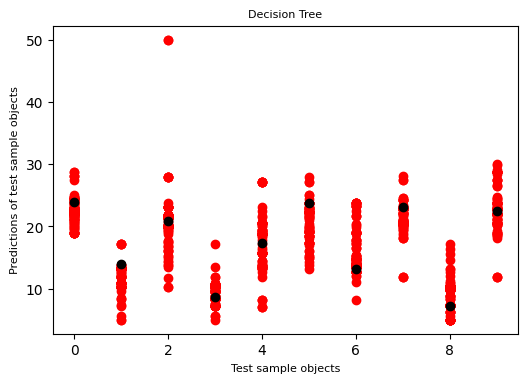

max_features =  10


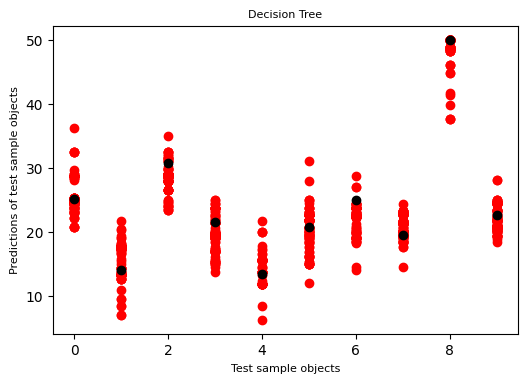

max_features =  11


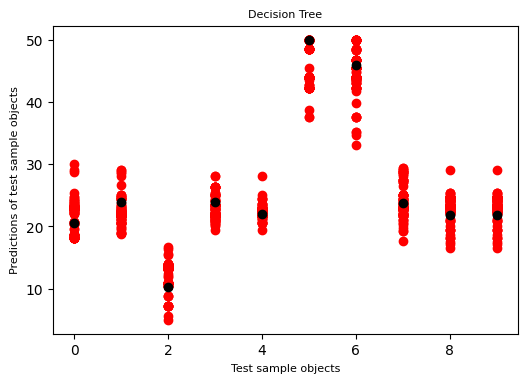

max_features =  12


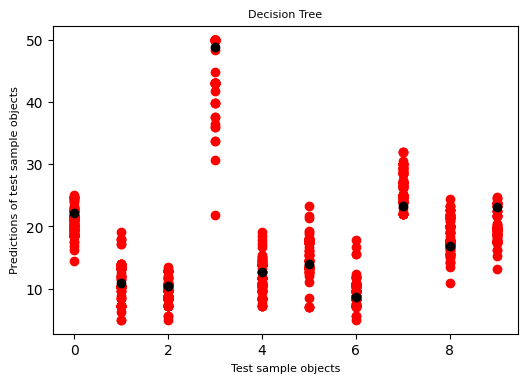

max_features =  13


In [20]:
for j  in range(1, X.shape[1]+1):

    plot_predictions(DecisionTreeRegressor(max_features = j), X, y, title = "Decision Tree")
    print("max_features = ", j)


Graphs showing the dependence of bias and variance on `n_estimators` (over the grid `2**np.arange(1, 10)`) for Random Forest and Gradient Boosting.

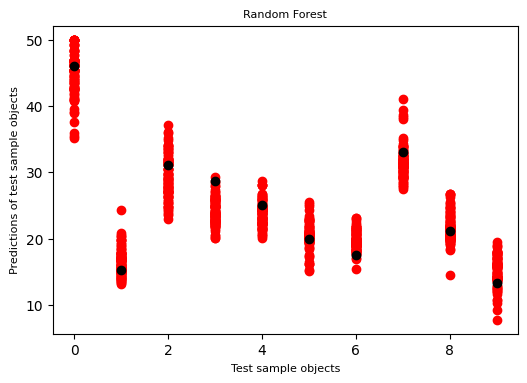

n_estimators =  2


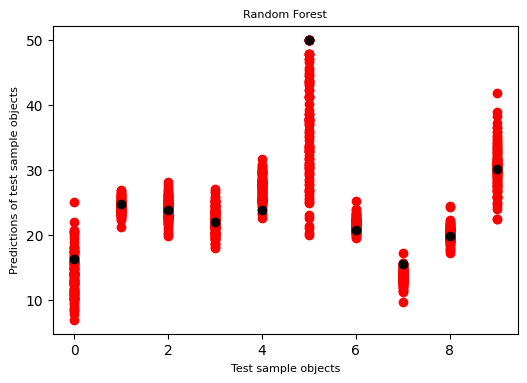

n_estimators =  4


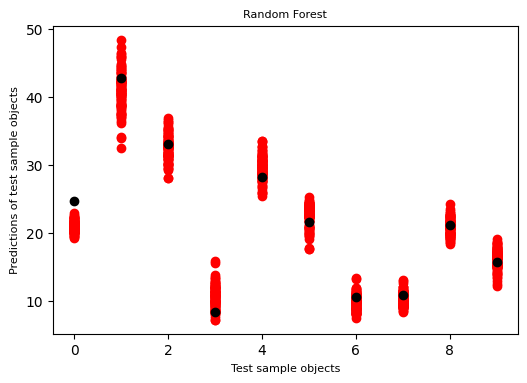

n_estimators =  8


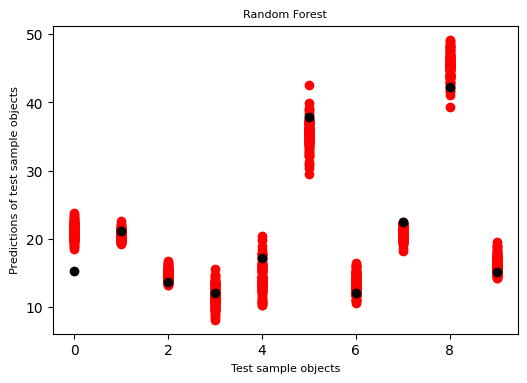

n_estimators =  16


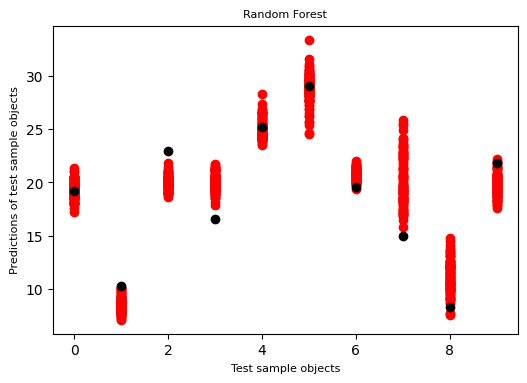

n_estimators =  32


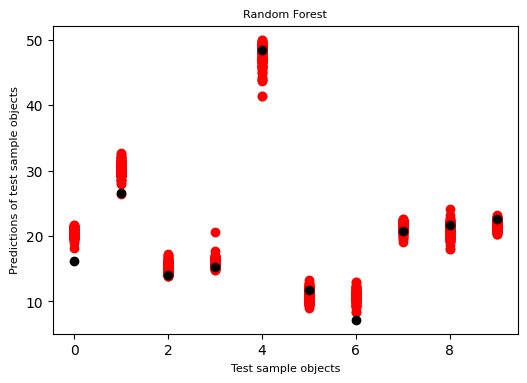

n_estimators =  64


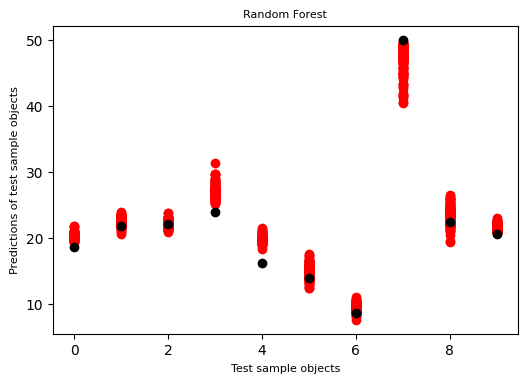

n_estimators =  128


In [21]:
n_estimators1 = 2**np.arange(1, 8)

for j  in n_estimators1:

    plot_predictions(RandomForestRegressor(n_estimators = j), X, y, title = "Random Forest")
    print("n_estimators = ", j)

For Random Forest, it's observed that as `n_estimators` increases, variance decreases significantly, which aligns with theory. More trees generally lead to lower variance. However, the bias remains roughly the same.

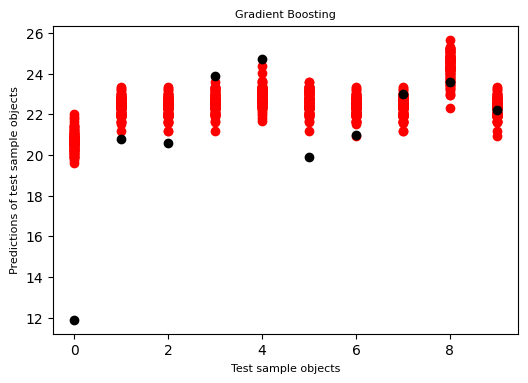

n_estimators =  2


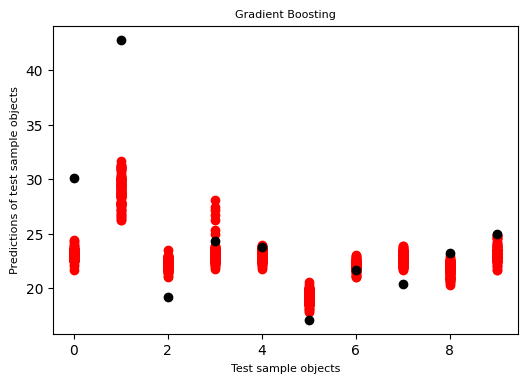

n_estimators =  4


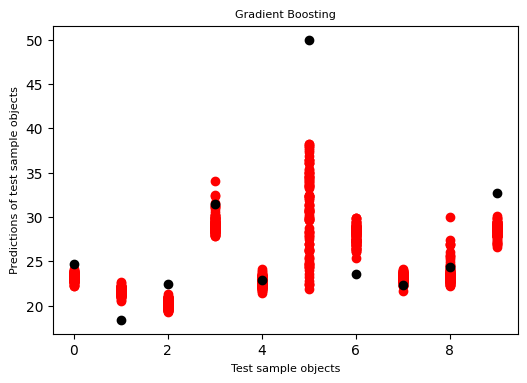

n_estimators =  8


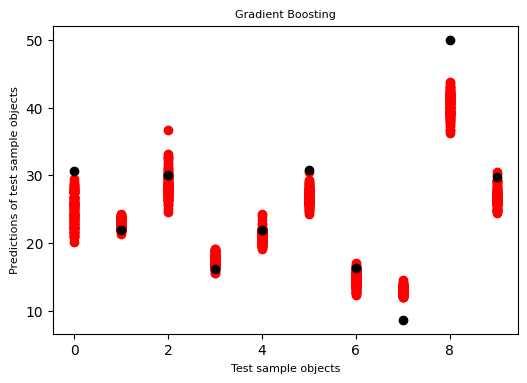

n_estimators =  16


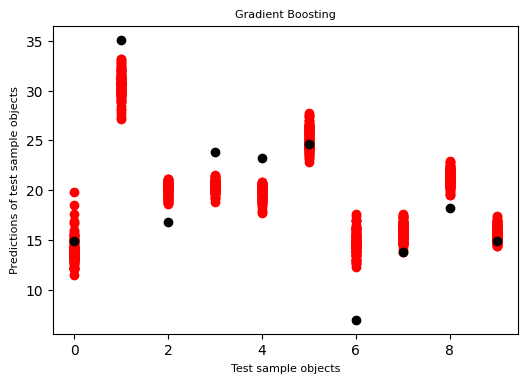

n_estimators =  32


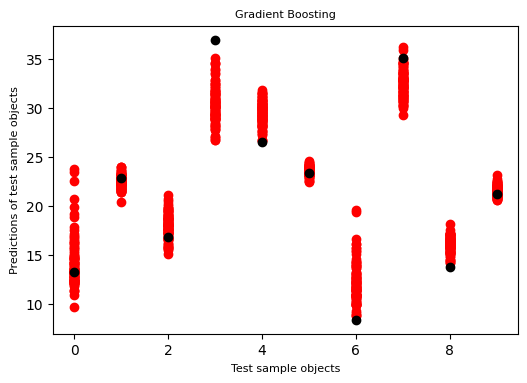

n_estimators =  64


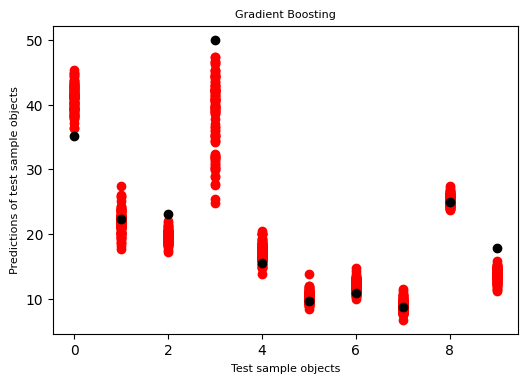

n_estimators =  128


In [22]:
from sklearn.ensemble import GradientBoostingRegressor

for j  in n_estimators1:

    plot_predictions(GradientBoostingRegressor(n_estimators = j), X, y, title = "Gradient Boosting")
    print("n_estimators = ", j)


For Gradient Boosting, the bias decreases and the variance increases as `n_estimators` grows. Initially, the predictions are tightly clustered, but they start to fluctuate with more trees. For small values of `n_estimators`, the bias is high, but it decreases quickly, and by `n_estimators=64`, the model has a lower bias than previous configurations.


For `max_depth`, it's evident that the bias improves with greater depth, as the model becomes more flexible. However, the variance increases because the tree starts to fit each observation more closely, leading to overfitting.

In [23]:
for j in range(1, 11):
    bias, error, variance = compute_biase_variance(DecisionTreeRegressor(max_depth = j), X, y)
    print("max_depth = ", j,"bias = ",  bias,"variance = ",  variance)

max_depth =  1 bias =  37.85928616911029 variance =  14.263147240914341
max_depth =  2 bias =  22.90835618749939 variance =  8.135722527832515
max_depth =  3 bias =  16.15571349808129 variance =  10.394893450941751
max_depth =  4 bias =  12.972079781391944 variance =  9.696144597286777
max_depth =  5 bias =  11.679619537610561 variance =  9.936511773529531
max_depth =  6 bias =  11.429753558722718 variance =  10.79074649520069
max_depth =  7 bias =  10.863338044528252 variance =  11.400362095961313
max_depth =  8 bias =  10.570185749505514 variance =  11.960619817474388
max_depth =  9 bias =  10.404912117454858 variance =  12.335990844226075
max_depth =  10 bias =  10.305494221050646 variance =  12.491590641024569


As shown by the calculation, the bias actually begins to decrease. On the other hand, the variance tends to increase on average.

For `max_features`, it's evident that considering fewer features increases the likelihood of losing some information about the model, leading to higher variance and higher bias. Consequently, as the number of features increases, both variance and bias should decrease.

In [24]:
for j in range(1, X.shape[1]+1):
    bias, error, variance = compute_biase_variance(DecisionTreeRegressor(max_features = j), X, y)
    print("max_features = ", j,"bias = ",  bias,"variance = ",  variance)

max_features =  1 bias =  13.703373324628298 variance =  29.854893570383453
max_features =  2 bias =  10.973590554762586 variance =  24.736057140837584
max_features =  3 bias =  9.973983851472374 variance =  21.38386164796447
max_features =  4 bias =  9.52407465768461 variance =  19.17611744500087
max_features =  5 bias =  9.468593110954963 variance =  17.585987548627948
max_features =  6 bias =  9.389698895507772 variance =  16.48044174396235
max_features =  7 bias =  9.25896531104481 variance =  15.485018868825343
max_features =  8 bias =  9.543445693194265 variance =  15.224006843885762
max_features =  9 bias =  9.718368378958063 variance =  14.414747395719326
max_features =  10 bias =  9.672554578605261 variance =  13.92494486930178
max_features =  11 bias =  9.848235882814794 variance =  13.597020578226154
max_features =  12 bias =  10.091565164837505 variance =  13.193635056442643
max_features =  13 bias =  10.230453053434177 variance =  13.016147316523309


In [25]:
for j  in n_estimators1:
    bias, error, variance = compute_biase_variance(RandomForestRegressor(n_estimators = j), X, y)
    print("n_estimators = ", j,"bias = ",  bias,"variance = ",  variance)

n_estimators =  2 bias =  10.593918451571305 variance =  8.426046421250788
n_estimators =  4 bias =  10.649936935317749 variance =  5.225195588781697
n_estimators =  8 bias =  10.71127224838861 variance =  3.679622244463811
n_estimators =  16 bias =  10.637396477681918 variance =  2.890350192475416
n_estimators =  32 bias =  10.612630870022986 variance =  2.531376867868859
n_estimators =  64 bias =  10.635035499923308 variance =  2.2620781830061825
n_estimators =  128 bias =  10.543879553121302 variance =  2.1371999708446783


As the number of `n_estimators` increases, the variance decreases. The bias remains approximately the same.

In [26]:
for j  in n_estimators1:
    bias, error, variance = compute_biase_variance(GradientBoostingRegressor(n_estimators = j), X, y)
    print("n_estimators = ", j,"bias = ",  bias,"variance = ",  variance)

n_estimators =  2 bias =  62.54207976027519 variance =  0.38112951263905215
n_estimators =  4 bias =  47.4267453293756 variance =  0.6573439238678684
n_estimators =  8 bias =  29.53599978023491 variance =  1.0408841799529052
n_estimators =  16 bias =  16.307951918825875 variance =  1.3824186082358318
n_estimators =  32 bias =  11.10582577525938 variance =  1.6570207929671652
n_estimators =  64 bias =  9.582144566305367 variance =  1.8854505238164438
n_estimators =  128 bias =  8.997177617141773 variance =  2.1264247416313933
